# Import libraries

In [1]:
from google.colab import drive
#drive.mount('/content/gdrive/')
drive.mount("/content/gdrive/", force_remount=True)

Mounted at /content/gdrive/


In [2]:
%cd "/content/gdrive/My Drive/Colab Notebooks/LADMM_Net_Pytorch"
%ls

/content/gdrive/My Drive/Colab Notebooks/LADMM_Net_Pytorch
calib32.mat
data/
FusionTestHarvard.ipynb
ISTAFusionTestHarvard.ipynb
ISTA_psnr_vs_epochs_layer_10_ratio_25.mat
ISTA_psnr_vs_epochs_layer_10_ratio_375.mat
ISTA_psnr_vs_epochs_layer_10_ratio_50.mat
ISTASimulationTestHarvard.ipynb
ISTATrainHarvardDataset.ipynb
models/
psnr_vs_epochs_layer_10_ratio_25.mat
psnr_vs_epochs_layer_10_ratio_375.mat
psnr_vs_epochs_layer_10_ratio_50.mat
psnr_vs_epochs_layer_5_ratio_25.mat
psnr_vs_epochs_layer_5_ratio_375.mat
psnr_vs_epochs_layer_5_ratio_50.mat
psnr_vs_epochs_layer_7_ratio_25.mat
psnr_vs_epochs_layer_7_ratio_375.mat
psnr_vs_epochs_layer_7_ratio_50.mat
recoverista.eps
SimulationTestHarvard.ipynb
TrainHarvardDataset.ipynb
train_parameters/
utils/
xyz.mat


In [3]:
import os
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import scipy.io as sio

# our libraries
from utils import featurefusionpkg as ff

from models.LadmmNet import LADMMcsifusionfastNet
# Pytorch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

gpu_list = '0'
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = gpu_list
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Measurement matrices

In [4]:
# Loading hyperspectral coded aperture
fname1       = 'cca_hs.mat'
data_path    = os.path.join(os.getcwd(),'data/Harvard/csi_measurements/50')
#data_path    = os.path.join(os.getcwd(),'data/Harvard/csi_measurements/375')
cca_hs       = sio.loadmat(os.path.join(data_path, fname1))['cca_hs']
shots_hs, M_hs, N_hs, L = cca_hs.shape
ccahs_np     = np.zeros((shots_hs*M_hs*N_hs*L))
for i in range(0,shots_hs):
  ccahs_np[i*M_hs*N_hs*L:(i+1)*M_hs*N_hs*L] = cca_hs[i,:,:,:].reshape((M_hs*N_hs*L),order='F')
ccahs        = torch.from_numpy(np.double(ccahs_np)).type(torch.FloatTensor)
del cca_hs, ccahs_np
ccahs = ccahs.view(-1,L,M_hs,N_hs).to(device)

# Loading multispectral coded aperture
fname1       = 'cca_ms.mat'
cca_ms       = sio.loadmat(os.path.join(data_path, fname1))['cca_ms']
shots_ms, M, N, L_ms = cca_ms.shape
ccams_np     = np.zeros((shots_ms*M*N*L_ms))
for i in range(0,shots_ms):
  ccams_np[i*M*N*L_ms:(i+1)*M*N*L_ms] = cca_ms[i,:,:,:].reshape((M*N*L_ms),order='F')
ccams        = torch.from_numpy(np.double(ccams_np)).type(torch.FloatTensor)
del cca_ms, ccams_np
ccams = ccams.view(-1,L_ms,M,N).to(device)

p = 4
q = 2

# LADMM parameters

In [5]:
np.random.seed(100)

layer_num               = 10
learning_rate           = 0.0005
epochs                  = 256
epochs                  = epochs + 1
num_training_samples    = 48
num_samples             = 48
batch_size              = 1
compression_ratio       = 50

model = LADMMcsifusionfastNet(layer_num)
model = nn.DataParallel(model)
model= model.to(device)

print_flag = 1
if print_flag:
    num_count = 0
    for para in model.parameters():
        num_count += 1
        print('Layer %d' % num_count)
        print(para.size())

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

indices         = np.random.permutation(num_samples)
train_indices   = indices[:num_training_samples]
sample_path     = os.path.join(os.getcwd(),'data/Harvard/csi_measurements/%d'%(compression_ratio))
data_path       = os.path.join(os.getcwd(),'data/Harvard/high_resolution_images')
model_dir       = "./train_parameters/Harvard/LADMM_Net_layer_%d_ratio_%d" % (layer_num, compression_ratio)

Layer 1
torch.Size([1])
Layer 2
torch.Size([1])
Layer 3
torch.Size([1])
Layer 4
torch.Size([1])
Layer 5
torch.Size([64, 32, 3, 3])
Layer 6
torch.Size([32, 64, 3, 3])
Layer 7
torch.Size([64, 32, 3, 3])
Layer 8
torch.Size([32, 64, 3, 3])
Layer 9
torch.Size([1])
Layer 10
torch.Size([1])
Layer 11
torch.Size([1])
Layer 12
torch.Size([1])
Layer 13
torch.Size([64, 32, 3, 3])
Layer 14
torch.Size([32, 64, 3, 3])
Layer 15
torch.Size([64, 32, 3, 3])
Layer 16
torch.Size([32, 64, 3, 3])
Layer 17
torch.Size([1])
Layer 18
torch.Size([1])
Layer 19
torch.Size([1])
Layer 20
torch.Size([1])
Layer 21
torch.Size([64, 32, 3, 3])
Layer 22
torch.Size([32, 64, 3, 3])
Layer 23
torch.Size([64, 32, 3, 3])
Layer 24
torch.Size([32, 64, 3, 3])
Layer 25
torch.Size([1])
Layer 26
torch.Size([1])
Layer 27
torch.Size([1])
Layer 28
torch.Size([1])
Layer 29
torch.Size([64, 32, 3, 3])
Layer 30
torch.Size([32, 64, 3, 3])
Layer 31
torch.Size([64, 32, 3, 3])
Layer 32
torch.Size([32, 64, 3, 3])
Layer 33
torch.Size([1])
Layer 34

# Training stage

Se han truncado las últimas 5000 líneas del flujo de salida.
222 25
[222/257] Total Loss: 0.0001, Discrepancy Loss: 0.0001,  Constraint Loss: 0.0000, PSNR: 39.44

222 26
[222/257] Total Loss: 0.0001, Discrepancy Loss: 0.0002,  Constraint Loss: 0.0000, PSNR: 37.81

222 27
[222/257] Total Loss: 0.0002, Discrepancy Loss: 0.0002,  Constraint Loss: 0.0000, PSNR: 36.13

222 28
[222/257] Total Loss: 0.0003, Discrepancy Loss: 0.0004,  Constraint Loss: 0.0001, PSNR: 34.33

222 29
[222/257] Total Loss: 0.0001, Discrepancy Loss: 0.0001,  Constraint Loss: 0.0000, PSNR: 38.80

222 30
[222/257] Total Loss: 0.0005, Discrepancy Loss: 0.0006,  Constraint Loss: 0.0001, PSNR: 32.26

222 31
[222/257] Total Loss: 0.0004, Discrepancy Loss: 0.0004,  Constraint Loss: 0.0001, PSNR: 33.78

222 32
[222/257] Total Loss: 0.0000, Discrepancy Loss: 0.0000,  Constraint Loss: 0.0000, PSNR: 45.11

222 33
[222/257] Total Loss: 0.0005, Discrepancy Loss: 0.0005,  Constraint Loss: 0.0000, PSNR: 32.86

222 34
[222/257] Tota

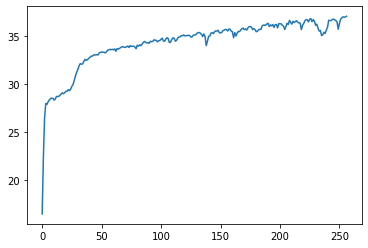

In [6]:
psnr = np.zeros(epochs)
def SpectralDegradationFilter(window_size, L, q):
  kernel = torch.zeros((L//q,L,window_size,window_size))
  for i in range(0,L//q):
    kernel[i,i*q:(i+1)*(q),window_size//2,window_size//2] = 1/q
  return kernel

def ProjectionFilter(window_size, L):
  kernel = torch.zeros((1,L,window_size,window_size))
  kernel[0,1:L,window_size//2,window_size//2] = 1
  return kernel

def SpectralUpsamplingFilter(window_size, q, L):
  kernel = torch.zeros((L,L//q,window_size,window_size))
  for i in range(0,L//q):
    for j in range(0,q):
      kernel[i*q+j,i,window_size//2,window_size//2] = 1 
  return kernel


# Training loop
for epoch_i in range(0, epochs):
    batch_iter  = num_training_samples // batch_size
    psnr_b      = np.zeros(batch_iter)
    for data in range(0,batch_iter):
      print(epoch_i, data)
      new_indices = train_indices[data*batch_size: data*batch_size + batch_size]       
            
      fnp = np.zeros((M*N*L*batch_size))
      for bs in range(0, batch_size):
      # Load compressive measurements
        fpointer        = new_indices[bs] + 1
        fsamples_ms     = 'hri_%03d.mat' % (fpointer)
        hri             = sio.loadmat(os.path.join(data_path, fsamples_ms))['foo']
        fnp[bs*M*N*L:(bs+1)*M*N*L] = hri.reshape((M*N*L),order='F')

      f = torch.from_numpy(np.double(fnp)).type(torch.FloatTensor)*(1/255.0)
      f = f.view(-1,L,M,N).to(device)

      # Acquisition process of the HS compressive measurements
      hs_deg        = nn.AvgPool2d(p)
      shot_data_hs  = torch.mean(torch.mul(ccahs,hs_deg(f).repeat(shots_hs, 1, 1, 1)),(1))
      shot_data_hs  = shot_data_hs * (1/torch.max(shot_data_hs))
      #shot_data_hs  = shot_data_hs + (0.01 * torch.randn((shot_data_hs.size())).to(device)) 

      # HS measurement matrix transpose
      HTyhs         = F.interpolate(torch.mean(torch.mul(shot_data_hs.view(shots_hs,1,M_hs,N_hs).repeat(1,L,1,1), ccahs),(0)).view(1,L,M_hs,N_hs),scale_factor=(p,p))
#      HTyhs2         = F.interpolate(torch.mean(shot_data_hs,(0)).repeat(L,1,1).view(1,L,M_hs,N_hs),scale_factor=(p,p))

      # Acquisition process of the MS compressive measurements
      kernel = SpectralDegradationFilter(3,L,q).to(device)
      shot_data_ms  = torch.mean(torch.mul(ccams,F.conv2d(f, kernel, padding=1).repeat(shots_ms, 1, 1, 1)),(1))
      shot_data_ms  = shot_data_ms * (1/torch.max(shot_data_ms))
      #shot_data_ms  = shot_data_ms + (0.01 * torch.randn((shot_data_ms.size())).to(device))

      # MS measurement matrix transpose
#      HTyms         = torch.mean(shot_data_ms,(0)).repeat(L,1,1).view(1,L,M,N)
      upsamp = SpectralUpsamplingFilter(3,q,L_ms*q).to(device)
      HTyms  = F.conv2d(torch.mean(torch.mul(shot_data_ms.view(shots_ms,1,M,N).repeat(1,L_ms,1,1), ccams),(0)).view(1,L_ms,M,N),upsamp, padding=1)
#      print(shot_data_ms.shape,ccams.shape, HTyms.shape)
#      plt.imshow(HTyhs[0,0,:,:].cpu())

      [x_output, loss_layers_sym] = model(ccahs, ccams, HTyhs, HTyms, M, N, L, p, q, shots_hs, shots_ms)
      del shot_data_hs, shot_data_ms, HTyhs, HTyms

      loss_constraint = torch.mean(torch.pow(loss_layers_sym[0], 2))   
      loss_discrepancy  = torch.mean(torch.pow(x_output - f, 2))
      del x_output, f, loss_layers_sym

      loss_all = torch.mul(0.90, loss_discrepancy) + torch.mul(0.10, loss_constraint)
      psnr_batch = torch.mul(10, torch.log10(torch.div(1.0, loss_discrepancy))) 
      psnr_b[data] = psnr_batch;

      optimizer.zero_grad()
      loss_all.backward()
      optimizer.step()

      output_data = "[%02d/%02d] Total Loss: %.4f, Discrepancy Loss: %.4f,  Constraint Loss: %.4f, PSNR: %.2f\n" % (epoch_i, epochs, loss_all.item(), loss_discrepancy.item(), loss_constraint, psnr_batch)
      print(output_data)
    psnr[epoch_i]= np.mean(psnr_b)
    print(psnr[epoch_i])
    sio.savemat('psnr_vs_epochs_layer_%d_ratio_%d.mat'%(layer_num, compression_ratio),{"psnr_vs_epochs":psnr})
    if epoch_i % 16 == 0:
      torch.save(model.state_dict(), "./%s/net_params_%d.pkl" % (model_dir, epoch_i))
        
plt.figure()
plt.plot(psnr)